# Solara

In [ ]:
#| default_exp solara

In [ ]:
#| exporti
from typing import Union, Tuple

import solara
import pandas as pd
import matplotlib.pyplot as plt

from professor_cheat_sheet.storage import ReadOnlyInMemorySQLite

In [ ]:
#| export
db = ReadOnlyInMemorySQLite()

In [ ]:
#| exporti
def db_get(data: Union[Tuple, solara.Reactive]):
    if data.value and isinstance(data.value, list):
        return data.value[0]

    return data.value

In [ ]:
#| export
unidade = solara.reactive(None)
componente = solara.reactive(None)
docente = solara.reactive(None)

In [ ]:
#| export
@solara.component
def SelectUnidade():
    values = db.execute_query('SELECT DISTINCT(unidade_responsavel) from data ORDER BY unidade_responsavel')
    solara.Select(label="Unidade", value=unidade, values=values)

In [ ]:
#| export
@solara.component
def SelectComponente():
    values = db.execute_query(
        f"""
        SELECT DISTINCT(nome_componente) from data 
        WHERE unidade_responsavel = '{db_get(unidade)}' 
        ORDER BY nome_componente
        """
    )
    solara.Select(label="Componente", value=componente, values=values)

In [ ]:
#| export
@solara.component
def SelectDocente():
    values = db.execute_query(
        f"""
        SELECT DISTINCT(nome_docente) from data 
        WHERE 
            unidade_responsavel = '{db_get(unidade)}' 
            AND 
            nome_componente = '{db_get(componente)}' 
        ORDER BY nome_componente
        """
    )
    solara.Select(label="Docente", value=docente, values=values)

In [ ]:
#| export
def PieChart():
    #solara.use_state(docente)
    
    q = f"""SELECT descricao, COUNT(*) as contagem
    FROM (
        SELECT DISTINCT discente, descricao
        FROM data
        WHERE unidade_responsavel = '{db_get(unidade)}'
        AND nome_componente = '{db_get(componente)}'
        AND nome_docente = '{db_get(docente)}'
    )
    GROUP BY descricao;
    """

    data = pd.read_sql_query(q, db.connection)

    data['porcentagem'] = (data['contagem'] / data['contagem'].sum()) * 100

    contagem_descricao = data['descricao'].value_counts()
    porcentagens = (contagem_descricao / contagem_descricao.sum()) * 100
    
    fig, ax = plt.subplots(figsize=(10, 6))
    wedges, texts, autotexts = ax.pie(porcentagens, labels=porcentagens.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
    
    for text, autotext in zip(texts, autotexts):
        text.set(size=10)
        autotext.set(size=10)
    
    legend_labels = [f"{label}: {value}" for label, value in zip(contagem_descricao.index, contagem_descricao.values)]
    ax.legend(wedges, legend_labels, title="Descrições", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    solara.FigureMatplotlib(fig)

In [ ]:
#| export
@solara.component
def Page():
    with solara.AppBarTitle():
        solara.Text("UFRN Cheat Sheet")

    with solara.Column():
        with solara.Row():
            SelectUnidade()
            SelectComponente()
            SelectDocente()
        PieChart()

Cannot show ipywidgets in text

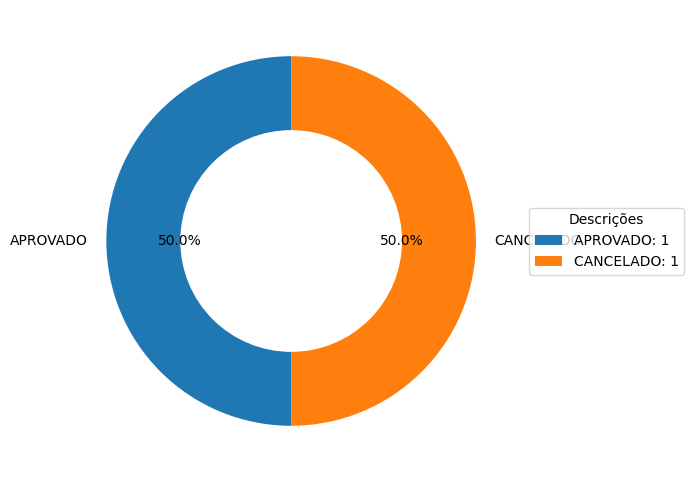

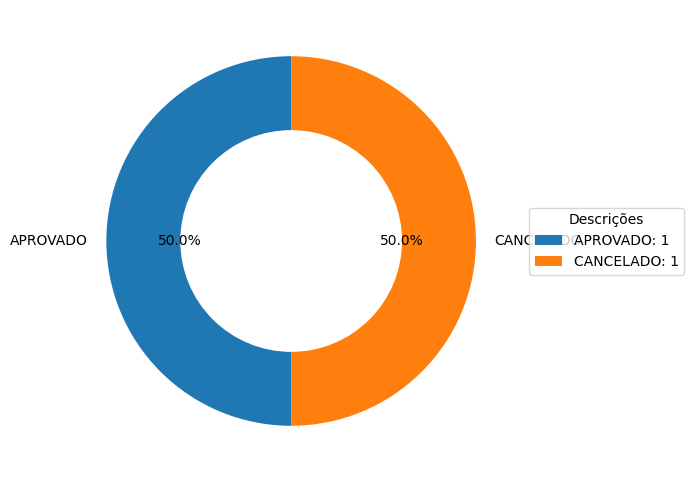

In [ ]:
#| export
Page()